In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib import request
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, accuracy_score, precision_recall_curve, f1_score

from sklearn.linear_model import LogisticRegression as LGR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB as GNB


%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# %load_ext rpy2.ipython

random_state = 1337

In [2]:
raw_df = pd.read_csv('../data/processed/protoss_2308_feb-08-2021_165940.csv', index_col=0)
df = raw_df.copy().loc[:,:'win']

drop_cols = ['player','frame','race']
df.drop(columns=drop_cols, inplace=True)

categorical_columns = df.columns[[t in ['object','bool'] for t in df.dtypes]]
continuous_columns = df.columns.difference(categorical_columns)

df.head()

,match_id,map_name,region,game_length,enemy_race,ap30s,second,workers_active_count,food_used,food_made,minerals_current,minerals_collection_rate,minerals_used_in_progress,minerals_used_current,minerals_used_active_forces,minerals_lost,vespene_current,vespene_collection_rate,vespene_used_in_progress,vespene_used_current,vespene_used_active_forces,vespene_lost,adept,archon,assimilator,carrier,colossus,cyberneticscore,darkshrine,darktemplar,disruptor,fleetbeacon,forge,gateway,hightemplar,immortal,interceptor,mothership,mothershipcore,nexus,observer,oracle,phoenix,photoncannon,probe,pylon,reactor,roboticsbay,roboticsfacility,sentry,shieldbattery,stalker,stargate,tempest,templararchive,twilightcouncil,voidray,warpgate,warpprism,zealot,win
0,1,World of Sleepers LE,us,437,T,0.0,0,12,12.0,15.0,50,0,0,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
1,1,World of Sleepers LE,us,437,T,310.8,30,13,14.0,15.0,50,727,150,1050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,1,World of Sleepers LE,us,437,T,366.8,60,15,16.0,23.0,115,867,125,1250,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
3,1,World of Sleepers LE,us,437,T,296.8,90,18,19.0,23.0,135,951,200,1475,0,0,12,44,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,18,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False
4,1,World of Sleepers LE,us,437,T,305.2,120,19,20.0,23.0,65,895,600,1525,0,0,56,111,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,19,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False


In [3]:
# match_ids = np.unique(df.match_id)
# idk = []

# for mid in match_ids:
#     curr_match = df[df.match_id == mid]
#     idk.append({
#         'match_id': mid,
#         'protoss_mean_vespene_used_current': curr_match[curr_match.race == 'P'].dropna()['vespene_used_current'].dropna().mean(),
#         'protoss_median_vespene_used_current': curr_match[curr_match.race == 'P'].dropna()['vespene_used_current'].dropna().median(),
#         'zerg_mean_vespene_used_current': curr_match[curr_match.race == 'Z'].dropna()['vespene_used_current'].dropna().mean(),
#         'zerg_median_vespene_used_current': curr_match[curr_match.race == 'Z'].dropna()['vespene_used_current'].dropna().median()
#     })

# pd.DataFrame(idk)

In [4]:
map_df = df.groupby(['enemy_race'], as_index=False)
map_df = map_df['minerals_current'].mean().sort_values('minerals_current', ascending=False).reset_index(drop=True)
map_df

,enemy_race,minerals_current
0,Z,454.053557
1,T,338.374015
2,P,334.431051


In [5]:
maps = ['Eternal Empire LE', 'Ever Dream LE', 'Deathaura LE', 'Ice and Chrome LE', 'Pillars of Gold LE']
map_df = df[df.map_name.isin(maps)].groupby(['enemy_race','map_name'], as_index=False)
show_df = map_df['minerals_used_current'].mean().sort_values('minerals_used_current', ascending=False).reset_index(drop=True).sort_values('enemy_race', ascending=False).reset_index(drop=True)
show_df

,enemy_race,map_name,minerals_used_current
0,Z,Ice and Chrome LE,10331.515892
1,Z,Eternal Empire LE,9034.909557
2,Z,Deathaura LE,8622.332988
3,Z,Ever Dream LE,8304.053571
4,Z,Pillars of Gold LE,7941.357362
5,T,Eternal Empire LE,8746.358555
6,T,Ice and Chrome LE,8487.679439
7,T,Deathaura LE,8202.839355
8,T,Pillars of Gold LE,6937.914079
9,T,Ever Dream LE,6583.885942


In [6]:
maps = ['Eternal Empire LE', 'Ever Dream LE', 'Deathaura LE', 'Ice and Chrome LE', 'Pillars of Gold LE']
map_df = df[df.map_name.isin(maps)].groupby(['enemy_race','map_name'], as_index=False)
show_df = map_df['vespene_used_current'].mean().sort_values('vespene_used_current', ascending=False).reset_index(drop=True).sort_values('enemy_race', ascending=False).reset_index(drop=True)
show_df

,enemy_race,map_name,vespene_used_current
0,Z,Ice and Chrome LE,2331.575271
1,Z,Eternal Empire LE,1880.532107
2,Z,Deathaura LE,1708.350596
3,Z,Ever Dream LE,1631.354167
4,Z,Pillars of Gold LE,1559.023517
5,T,Eternal Empire LE,1613.191459
6,T,Ice and Chrome LE,1486.683756
7,T,Deathaura LE,1400.488281
8,T,Pillars of Gold LE,1081.651139
9,T,Ever Dream LE,944.742327


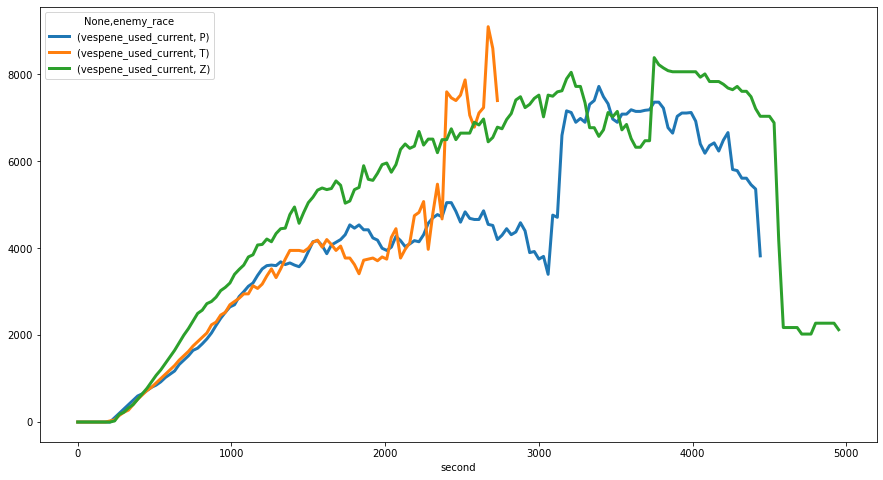

In [7]:
s = pd.DataFrame(df[['second','enemy_race','vespene_used_current']].groupby(['second', 'enemy_race'])['enemy_race','vespene_used_current'].median().unstack())
s.plot(figsize=(15,8), linewidth=3)
plt.show()

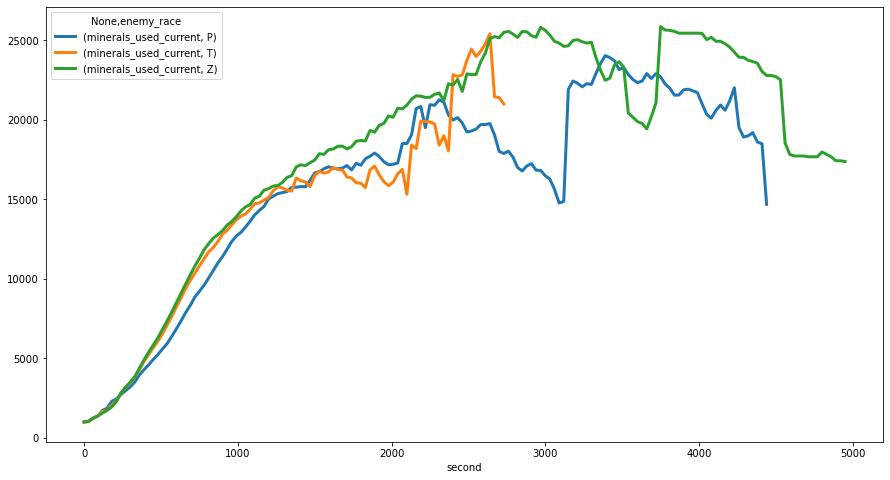

In [8]:
s = pd.DataFrame(df[['second','enemy_race','minerals_used_current']].groupby(['second', 'enemy_race'])['enemy_race','minerals_used_current'].mean().unstack())
s.plot(figsize=(15,8), linewidth=3)
plt.show()

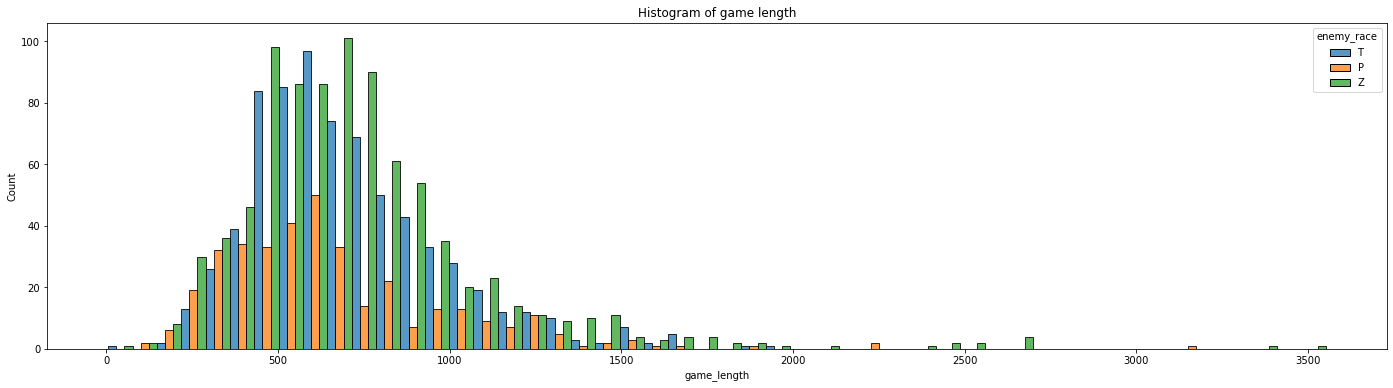

In [25]:
grouped_df = df.loc[:, ['match_id', 'map_name', 'game_length', 'region', 'enemy_race', 'win']]
grouped_df = grouped_df.groupby(grouped_df['match_id']).head(1)

plt.figure(figsize=(24, 6))
ax = sns.histplot(data=grouped_df, x='game_length', hue='enemy_race', multiple='dodge', bins=50)
plt.title('Histogram of game length')

plt.show()

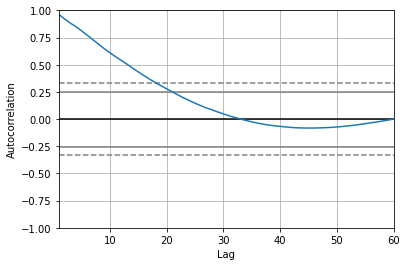

In [229]:
minerals_types = df.groupby('second')['second','minerals_current', 'minerals_collection_rate','minerals_used_in_progress','minerals_used_current','minerals_lost','minerals_killed','minerals_used_active_forces'].mean().dropna()
pd.plotting.autocorrelation_plot(minerals_types)
plt.show()

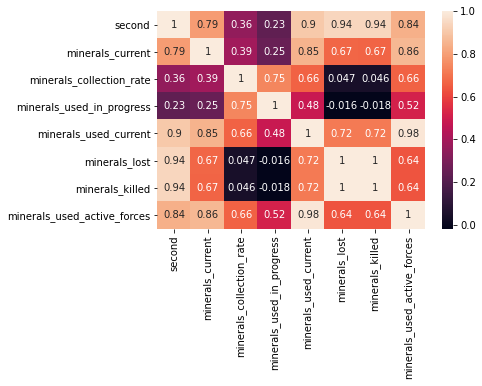

In [230]:
sns.heatmap(minerals_types.corr(), annot=True)
plt.show()

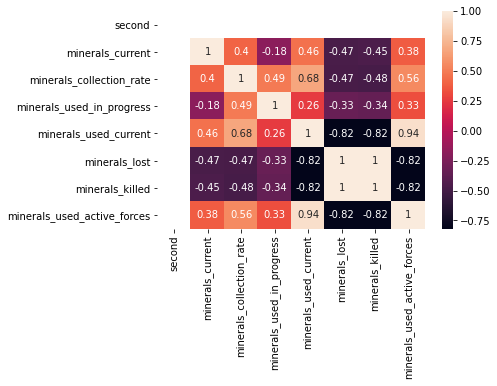

In [231]:
sns.heatmap(minerals_types.diff().corr(), annot=True)
plt.show()

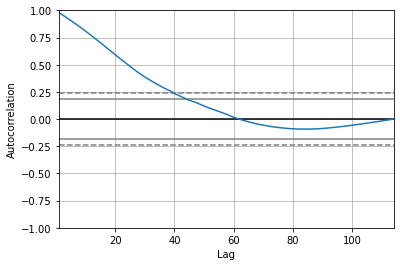

In [103]:
vespene_types = df.groupby('second')['second','vespene_current', 'vespene_collection_rate','vespene_used_in_progress','vespene_used_current','vespene_lost','vespene_killed','vespene_used_active_forces'].mean().dropna()
pd.plotting.autocorrelation_plot(vespene_types)
plt.show()

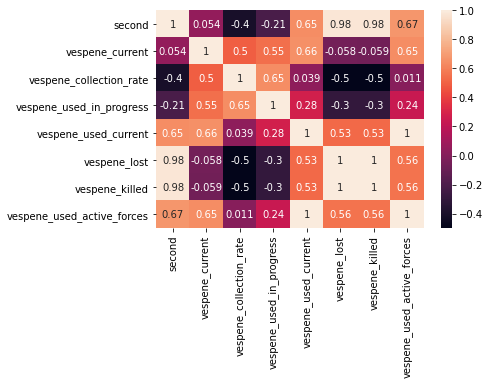

In [104]:
sns.heatmap(vespene_types.corr(), annot=True)
plt.show()

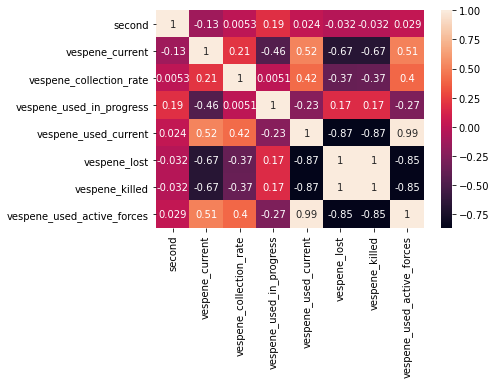

In [105]:
sns.heatmap(vespene_types.diff().corr(), annot=True)
plt.show()

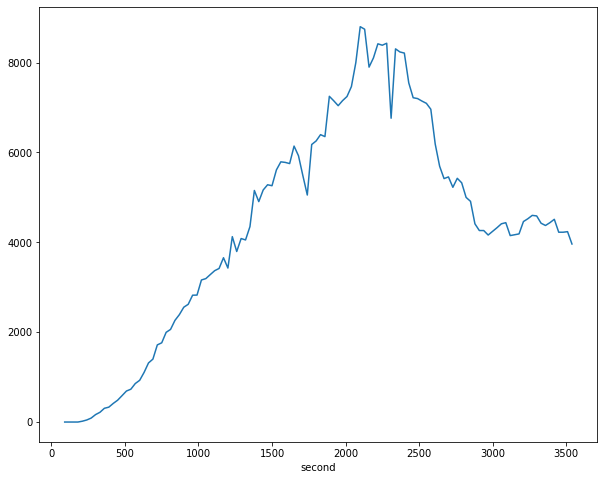

In [191]:
s_df = df.groupby('second')['vespene_used_current'].mean().dropna()
s_df.plot(figsize=(10,8))
plt.show()

In [26]:
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')
arima_model = sm.tsa.statespace.SARIMAX(df)

arima_model = arima_model.fit()
arima_model.plot_diagnostics(figsize=(15,12))
plt.show()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

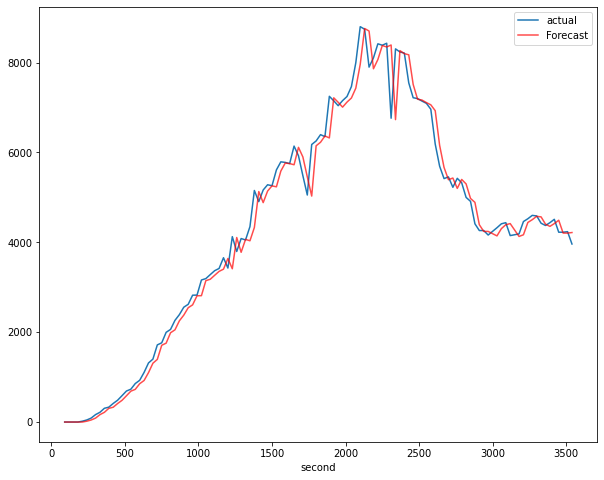

In [205]:
pred = arima_model.get_prediction(dynamic=False)
pred_ci = pred.conf_int()

ax = s_df.plot(label='actual', figsize=(10,8))
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.7, color='red')
plt.legend()
plt.show()

In [159]:
# since svm's are based around euclidean distance we will
# be one-hot encoding our categorical features
df_ohe = pd.get_dummies(df.copy(), columns=categorical_columns, drop_first=True)

# get_dummies renames response to response_>50K
# so, renaming it back to response
df_ohe.rename(columns={'win_True':'win'}, inplace=True)

X = df_ohe.loc[:,df_ohe.columns.difference(['win'])].to_numpy()
y = df_ohe.loc[:,'win'].to_numpy()

X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X, y, test_size=.2, random_state=random_state)
X_test_ohe = X[30:((30+52)//2)]
y_test_ohe = y[30:((30+52)//2)]

In [160]:
# tree models tend to perform better when not one-hot encoding
df_cat = df.copy()
for col in categorical_columns:
    df_cat[col] = df_cat[col].astype('category').cat.codes

X = df_cat.loc[:,df_cat.columns.difference(['win'])].to_numpy()
y = df_cat.loc[:,'win'].to_numpy()

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, test_size=.2, random_state=random_state)
X_test_cat = X[30:((30+52)//2)]
y_test_cat = y[30:((30+52)//2)]

In [161]:
def get_model(model, X_train=None, y_train=None, X_test=None, y_test=None, tag=''):
    m = eval(model)()
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)

    print('{} {} | {} {}'.format('-'*5,model,tag,'-'*5))
    print('What is the test error of the model obtained? %.4f' % (1-np.mean(y_pred == y_test)))
    print('Revenue predicted classes from %s model:' % model)
    for row in confusion_matrix(y_test, y_pred): print(row)
    print()
    
    return m

In [162]:
data = {'ohe': {}, 'cat': {}}
for k in data:
    data[k]['tag'] = k
    for name in ['X_train', 'y_train', 'X_test', 'y_test']:
        data[k][name] = eval('{}_{}'.format(name,k))

for k in data:
    lgr_model = get_model('LGR', **data[k])
    lda_model = get_model('LDA', **data[k])
    qda_model = get_model('QDA', **data[k])
    gnb_model = get_model('GNB', **data[k])

----- LGR | ohe -----
What is the test error of the model obtained? 0.6364
Revenue predicted classes from LGR model:
[1 4]
[3 3]

----- LDA | ohe -----
What is the test error of the model obtained? 0.3636
Revenue predicted classes from LDA model:
[1 4]
[0 6]

----- QDA | ohe -----
What is the test error of the model obtained? 0.4545
Revenue predicted classes from QDA model:
[0 5]
[0 6]

----- GNB | ohe -----
What is the test error of the model obtained? 0.5455
Revenue predicted classes from GNB model:
[5 0]
[6 0]

----- LGR | cat -----
What is the test error of the model obtained? 0.6364
Revenue predicted classes from LGR model:
[1 4]
[3 3]

----- LDA | cat -----
What is the test error of the model obtained? 0.4545
Revenue predicted classes from LDA model:
[0 5]
[0 6]

----- QDA | cat -----
What is the test error of the model obtained? 0.4545
Revenue predicted classes from QDA model:
[4 1]
[4 2]

----- GNB | cat -----
What is the test error of the model obtained? 0.5455
Revenue predict

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.utils import plot_model

%tensorflow_version 2.x
%matplotlib inline

UsageError: Line magic function `%tensorflow_version` not found.


In [3]:
#@title Theme Function (double-click for code) { display-mode: "form" }
def theme(color='light'):
  rc_params = None
  fontdict = None
  if color is 'dark':
    rc_params = {'ytick.color':'w',
          'xtick.color':'w',
          'axes.labelcolor':'w',
          'axes.edgecolor':'w'}
    fontdict = {'color':'w'}
  else:
    rc_params = {'ytick.color' : 'k',
          'xtick.color' : 'k',
          'axes.labelcolor' : 'k',
          'axes.edgecolor' : 'k'}
    fontdict = {'color':'k'}
  return rc_params, fontdict

In [4]:
"""
Uncomment if using dark theme in colab
"""
# rc_params, fontdict = theme('light')
rc_params, fontdict = theme('dark')

In [5]:
#@title EarlyStopping Class Implementation (double-click for code) { display-mode: "form" }
# Source: https://www.tensorflow.org/guide/keras/custom_callback#early_stopping_at_minimum_loss

class EarlyStopping(keras.callbacks.Callback):
  """
  Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
    patience: Number of epochs to wait after min has been hit. After this
    number of no improvement, training stops.
  """

  def __init__(self, patience=0, metric='val_loss'):
    super(EarlyStopping, self).__init__()

    self.patience = patience
    self.metric = metric

    # best_weights to store the weights at which the minimum loss occurs.
    self.best_weights = None

  def on_train_begin(self, logs=None):
    # The number of epoch it has waited when loss is no longer minimum.
    self.wait = 0
    # The epoch the training stops at.
    self.stopped_epoch = 0
    # Initialize the best as infinity.
    self.best = np.Inf

  def on_epoch_end(self, epoch, logs=None):
    current = None
    if self.metric == 'just right':
      train_loss = logs.get('loss')
      val_loss = logs.get('val_loss')
      current = abs(train_loss-val_loss)
    else:
      current = logs.get(self.metric)

    if np.less(current, self.best):
      self.best = current
      self.wait = 0
      # Record the best weights if current results is better (less).
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
    if self.wait >= self.patience:
      self.stopped_epoch = epoch
      self.model.stop_training = True
      self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print('Epoch %d: early stopping (best epoch %d)' % (self.stopped_epoch+1, self.stopped_epoch+1-self.patience))

In [6]:
conv = lambda w,k,p,s: (w-k+2*p)//s+1
maxp = lambda w,f,s: (w-f)//s+1
trans = lambda w,k,p,s: (w-1)*s+k-2*p

a = 32
print('input: (%d,%d,%d)' % (a,a,3))
a = conv(a,3,0,1)
print('conv: (%d,%d,%d)' % (a,a,32))
a = conv(a,3,0,1)
print('conv: (%d,%d,%d)' % (a,a,32))
a = maxp(a,2,1)
print('max: (%d,%d,%d)' % (a,a,32))
a = trans(a,5,0,1)
print('trans: (%d,%d,%d)' % (a,a,64))

a = conv(a,3,0,2)
print('conv: (%d,%d,%d)' % (a,a,64))
a = conv(a,3,0,2)
print('conv: (%d,%d,%d)' % (a,a,64))
a = maxp(a,2,2)
print('max: (%d,%d,%d)' % (a,a,64))
a = trans(a,5,0,1)

a = conv(a,3,0,1)
print('conv: (%d,%d,%d)' % (a,a,128))
a = conv(a,3,0,1)
print('conv: (%d,%d,%d)' % (a,a,128))
a = maxp(a,2,1)
print('max: (%d,%d,%d)' % (a,a,128))

input: (32,32,3)
conv: (30,30,32)
conv: (28,28,32)
max: (27,27,32)
trans: (31,31,64)
conv: (15,15,64)
conv: (7,7,64)
max: (3,3,64)
conv: (5,5,128)
conv: (3,3,128)
max: (2,2,128)


In [7]:
def get_just_right_model(optimizer=None, lr=None, input_shape=None):
  opt = optimizer(lr=lr)

  model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=1),
    keras.layers.Dropout(.2),

    keras.layers.Conv2DTranspose(64, kernel_size=(5,5), activation='relu'),
    keras.layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'),
    keras.layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    keras.layers.Dropout(.3),

    keras.layers.Conv2DTranspose(64, kernel_size=(5,5), activation='relu'),
    keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=1),
    keras.layers.Dropout(.4),

    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model